In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import signac
import pickle
import json
import math

TARGETS = ['COF', 'intercept']

In [106]:
project = signac.get_project()

job_data_array = np.array([0]*11)
idx2id = dict()

for i, job in enumerate(project.find_jobs()):
    
    idx2id[i] = job.id
    
    num_feat_COF = float(len(job.document['COF_features']))
    num_feat_intercept = float(len(job.document['intercept_features']))
    
    if job.sp.max_features == 'sqrt':
        max_features_intercept = round(math.sqrt(num_feat_intercept), 0)
        max_features_COF = round(math.sqrt(num_feat_COF), 0)
    elif job.sp.max_features == 'log2':
        max_features_intercept = round(math.log2(num_feat_intercept), 0)
        max_features_COF = round(math.log2(num_feat_COF), 0)
    else:
        assert(False), "max_features value of {} not recognized, \
            max_features should be 'log2' or 'sqrt'.".format(job.sp.max_features)
     
    max_depth = 2000.0 if not job.sp.max_depth else float(job.sp.max_depth)
    min_samples_split = float(job.sp.min_samples_split)
    min_samples_leaf = float(job.sp.min_samples_leaf)
    var_threshold = float(job.sp.var_threshold)
    corr_threshold = float(job.sp.corr_threshold)
    
    COF_score = float(job.document().get('COF_score'))
    intercept_score = float(job.document().get('intercept_score'))
    
    job_data_row = np.array([num_feat_COF, num_feat_intercept, \
                            max_features_COF, max_features_intercept, max_depth, \
                            min_samples_split, min_samples_leaf, var_threshold, \
                            corr_threshold, COF_score, intercept_score])
    job_data_array = np.vstack((job_data_array, job_data_row))

job_data_array = np.delete(job_data_array, 0, axis=0)
job_df = pd.DataFrame(job_data_array, columns=['num_feat_COF', 'num_feat_intercept', \
                                               'max_features_COF', 'max_features_intercept', \
                                               'max_depth', 'min_samples_split', \
                                               'min_samples_leaf', 'var_threshold', 'corr_threshold', \
                                               'COF_score', 'intercept_score'])

In [123]:
job_df

,num_feat_COF,num_feat_intercept,max_features_COF,max_features_intercept,max_depth,min_samples_split,min_samples_leaf,var_threshold,corr_threshold,COF_score,intercept_score
0,65.0,66.0,8.0,8.0,40.0,2.0,2.0,0.01,0.95,0.642215,0.883027
1,64.0,61.0,8.0,8.0,80.0,2.0,5.0,0.02,0.95,0.647287,0.868499
2,64.0,61.0,8.0,8.0,2000.0,5.0,1.0,0.02,0.95,0.636928,0.883203
3,40.0,40.0,5.0,5.0,60.0,5.0,5.0,0.03,0.90,0.643462,0.871335
4,52.0,52.0,7.0,7.0,20.0,5.0,1.0,0.01,0.90,0.637122,0.886231
...,...,...,...,...,...,...,...,...,...,...,...
805,65.0,66.0,6.0,6.0,80.0,10.0,2.0,0.01,0.95,0.645110,0.871097
806,40.0,40.0,6.0,6.0,2000.0,2.0,5.0,0.03,0.90,0.645891,0.877791
807,51.0,51.0,7.0,7.0,40.0,5.0,5.0,0.03,0.95,0.646047,0.873189
808,33.0,30.0,5.0,5.0,80.0,5.0,1.0,0.02,0.80,0.635460,0.887284


In [119]:
best_idx_COF = job_df.idxmax()['COF_score']
best_id_COF = idx2id[best_idx_COF]
best_job_COF = project.open_job(id=best_id_COF)

best_idx_intercept = job_df.idxmax()['intercept_score']
best_id_intercept = idx2id[best_idx_intercept]
best_job_intercept = project.open_job(id=best_id_intercept)

best_statepoint_COF = best_job_COF.sp
best_statepoint_intercept = best_job_intercept.sp
print('Best combination of parameters for predicting COF is\n{}\nJob ID: {}\nr^2 = {}'.format(
      best_statepoint_COF, best_id_COF, job_df.max()['COF_score']))
print('Best combination of parameters for predicting intercept is\n{}\nJob ID: {}\nr^2 = {}'.format(
      best_statepoint_intercept, best_id_intercept, job_df.max()['intercept_score']))

Best combination of parameters for predicting COF is
{'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 5, 'var_threshold': 0.01, 'corr_threshold': 0.95}
Job ID: 21a755aa4b3ae6d2556efdf563939ea5
r^2 = 0.6477194483578015
Best combination of parameters for predicting intercept is
{'max_features': 'sqrt', 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'var_threshold': 0.03, 'corr_threshold': 0.8}
Job ID: 01f2259c8b8ded041bcca2c3873e4be5
r^2 = 0.8947535490703858


In [120]:
# copy best COF and intercept trained models to project home directory

with open(best_job_COF.fn('COF_trained.pickle'), 'rb') as modelfile:
    model = pickle.load(modelfile)
    with open('trained-models/best_COF_trained.pickle', 'wb') as to_write:
        pickle.dump(model, to_write)
    print('Pickling out to best_COF_trained.pickle')
    
with open(best_job_intercept.fn('intercept_trained.pickle'), 'rb') as modelfile:
    model = pickle.load(modelfile)
    with open('trained-models/best_intercept_trained.pickle', 'wb') as to_write:
        pickle.dump(model, to_write)
    print('Pickling out to best_intercept_trained.pickle')

Pickling out to best_COF_trained.pickle
Pickling out to best_intercept_trained.pickle


In [121]:
# copy features included in best models to json file
best_features = dict()
best_features['COF'] = best_job_COF.document['COF_features']
best_features['intercept'] = best_job_intercept.document['intercept_features']

with open('json-files/best_features.json', 'w') as f:
    json.dump(best_features, f)

Text(0, 0.5, 'Frequency')

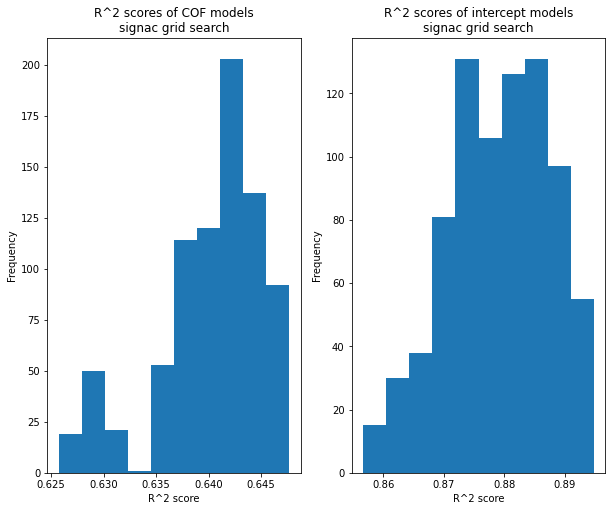

In [122]:
#plot histogram of distribution of model scores
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.hist(job_df['COF_score'], bins=10)
plt.title('R^2 scores of COF models\nsignac grid search')
plt.xlabel('R^2 score')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(job_df['intercept_score'], bins=10)
plt.title('R^2 scores of intercept models\nsignac grid search')
plt.xlabel('R^2 score')
plt.ylabel('Frequency')